# Full Cell Effect of C-Rate

In [23]:
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import savgol_filter

from matplotlib import pyplot as plt
import src.plotter as plotter

import warnings
warnings.filterwarnings('ignore')

In [24]:
plotter.initialize(plt)
output_path = 'outputs'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [25]:
data_path_1 = f'data/2022-08-29-fast-formation-round-2/chgdch-set-1'
data_path_2 = f'data/2022-08-29-fast-formation-round-2/chgdch-set-2'

In [26]:
file_list_1 = [Path(f'{data_path_1}/UMBL2022FEB_CELL152074_CHGDCH_1C_P45C_5P0PSI_20220927_R1.csv'),
               Path(f'{data_path_1}/UMBL2022FEB_CELL152074_CHGDCH_C2_P45C_5P0PSI_20220927_R1.csv'),
               Path(f'{data_path_1}/UMBL2022FEB_CELL152074_CHGDCH_C4_P45C_5P0PSI_20220928_R1.csv'),
               Path(f'{data_path_1}/UMBL2022FEB_CELL152074_CHGDCH_C10_P45C_5P0PSI_20220928_R1.csv'),
               Path(f'{data_path_1}/UMBL2022FEB_CELL152074_CHGDCH_C20_P45C_5P0PSI_20220929_R1.csv'),
               Path(f'{data_path_1}/UMBL2022FEB_CELL152074_CHGDCH_C50_P45C_5P0PSI_20221001_R1.csv'),
               Path(f'{data_path_1}/UMBL2022FEB_CELL152074_CHGDCH_C100_P45C_5P0PSI_20221006_R1.csv')]


file_list_2 = [Path(f'{data_path_2}/UMBL2022FEB_CELL152074_CHGDCH_1C_P45C_5P0PSI_20221013_R1.csv'),
               Path(f'{data_path_2}/UMBL2022FEB_CELL152074_CHGDCH_C2_P45C_5P0PSI_20221013_R1.csv'),
               Path(f'{data_path_2}/UMBL2022FEB_CELL152074_CHGDCH_C4_P45C_5P0PSI_20221013_R1.csv'),
               Path(f'{data_path_2}/UMBL2022FEB_CELL152074_CHGDCH_C10_P45C_5P0PSI_20221014_R1.csv'),
               Path(f'{data_path_2}/UMBL2022FEB_CELL152074_CHGDCH_C20_P45C_5P0PSI_20221015_R1.csv'),
               Path(f'{data_path_2}/UMBL2022FEB_CELL152074_CHGDCH_C50_P45C_5P0PSI_20221017_R1.csv')]

In [27]:
def process_data_set(file_list, chgstr='charge', is_normalized=False):
    """

    Parameters
    ----------
    chgstr (str): 'charge' or 'discharge'

    """

    # Declare some constants
    c_rate_dict = dict({'1C': 1, 
                        'C2': 0.5,
                        'C4': 0.25,
                        'C10': 0.1,
                        'C20': 0.05, 
                        'C50': 0.02,
                        'C100': 0.01 
                        })

    STEP_INDEX_CHARGE = 6
    STEP_INDEX_DISCHARGE = 9

    # Get the data 
    df_list = []
    c_rate_list = []

    for file in file_list:
        df_list.append(pd.read_csv(file))
        curr_c_rate_str = file.name.split('_')[3]
        c_rate_list.append(c_rate_dict[curr_c_rate_str])

    c_rate_array = np.array(c_rate_list)

    # Make the plot
    color = plt.cm.rainbow(np.linspace(0, 1, len(df_list)))
    fh = plt.figure(figsize=(8, 10))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)

    chg_cap_array = []
    chg_cap_cv_array = []
    dch_cap_array = []
    dch_cap_cv_array = []
    
    # offs = 0.08 * len(df_list)
    offs = 0

    for df, file, col, c_rate in zip(df_list, file_list, color, c_rate_array):
    # for df, file, col in zip(reversed(df_list), reversed(file_list), reversed(color)):

        df_chg = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_CHARGE)]
        df_dch = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_DISCHARGE)]

        df_chg_cv = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_CHARGE + 1)]
        df_dch_cv = df[(df['Cycle Number'] == 2) & (df['Step Index'] == STEP_INDEX_DISCHARGE + 1)]

        Q0 = np.max(df_chg['Charge Capacity (Ah)'])

        xc = df_chg['Charge Capacity (Ah)']
        xc = xc / np.max(xc) if is_normalized else xc
        yc = df_chg['Potential (V)']        

        print(len(xc))
        xd = df_dch['Discharge Capacity (Ah)']
        # xd = np.max(xd) - xd
        xd = xd/np.max(xd) if is_normalized else xd

        yd = df_dch['Potential (V)']
        dd = np.gradient(yd, xd) * np.max(df_dch['Discharge Capacity (Ah)'])

        # Get the filtered differential curves
        size_factor = 65
        window_length = int(len(xc) / size_factor)
        window_length = window_length + 1 if window_length % 2 == 0 else window_length
        polyorder = 2

        dQc = savgol_filter(xc, window_length, polyorder, 1)
        dVc = savgol_filter(yc, window_length, polyorder, 1)
        dQd = savgol_filter(xd, window_length, polyorder, 1)
        dVd = savgol_filter(yd, window_length, polyorder, 1)

        offs = offs + 0.08   

        if chgstr == 'charge':
            ax1.plot(xc, yc, color=col, label=f'{c_rate:.2f}C, {np.max(xc):.2f}Ah')
            ax2.plot(xc, np.abs(dVc/dQc)*Q0 + offs, c=col)
        elif chgstr == 'discharge':
            ax1.plot(xd, yd, color=col, label=f'{c_rate:.2f}C, {np.max(xd):.2f}Ah')
            ax2.plot(xd, np.abs(dVd/dQd)*Q0 + offs, c=col)

        chg_cap_array.append(np.max(xc))
        chg_cap_cv_array.append(np.max(df_chg_cv['Charge Capacity (Ah)']))
        dch_cap_array.append(np.max(xd))
        dch_cap_cv_array.append(np.max(df_dch_cv['Discharge Capacity (Ah)']))
        print(file.name)
        # print(f'{np.max(xc):.5f} Ah')
        # print('')

    ax2.set_ylim((0.2, 2.0))
    xlabel = 'SOC' if is_normalized else 'Capacity (Ah)'
    ax2.set_xlabel(xlabel)
    ax1.legend(fontsize=15)
    ax1.grid(False)
    ax2.grid(False)
    ax1.set_ylabel('Voltage (V)')
    ax2.set_ylabel('Q$_0$|dV/dQ| + $\\alpha$ (V)')

    plt.tight_layout()

    plt.savefig(f'{output_path}/fig_dvdq_details_full_cell_{chgstr}.png', dpi=300)

    res = dict()
    res['chg_cap_array'] = chg_cap_array
    res['chg_cap_cv_array'] = chg_cap_cv_array
    res['dch_cap_array'] = dch_cap_array
    res['dch_cap_cv_array'] = dch_cap_cv_array
    res['c_rate_array'] = c_rate_array
    
    return res


530
UMBL2022FEB_CELL152074_CHGDCH_1C_P45C_5P0PSI_20220927_R1.csv
824
UMBL2022FEB_CELL152074_CHGDCH_C2_P45C_5P0PSI_20220927_R1.csv
1507
UMBL2022FEB_CELL152074_CHGDCH_C4_P45C_5P0PSI_20220928_R1.csv
3612
UMBL2022FEB_CELL152074_CHGDCH_C10_P45C_5P0PSI_20220928_R1.csv
7231
UMBL2022FEB_CELL152074_CHGDCH_C20_P45C_5P0PSI_20220929_R1.csv
18312
UMBL2022FEB_CELL152074_CHGDCH_C50_P45C_5P0PSI_20221001_R1.csv
18284
UMBL2022FEB_CELL152074_CHGDCH_C100_P45C_5P0PSI_20221006_R1.csv
530
UMBL2022FEB_CELL152074_CHGDCH_1C_P45C_5P0PSI_20220927_R1.csv
824
UMBL2022FEB_CELL152074_CHGDCH_C2_P45C_5P0PSI_20220927_R1.csv
1507
UMBL2022FEB_CELL152074_CHGDCH_C4_P45C_5P0PSI_20220928_R1.csv
3612
UMBL2022FEB_CELL152074_CHGDCH_C10_P45C_5P0PSI_20220928_R1.csv
7231
UMBL2022FEB_CELL152074_CHGDCH_C20_P45C_5P0PSI_20220929_R1.csv
18312
UMBL2022FEB_CELL152074_CHGDCH_C50_P45C_5P0PSI_20221001_R1.csv
18284
UMBL2022FEB_CELL152074_CHGDCH_C100_P45C_5P0PSI_20221006_R1.csv


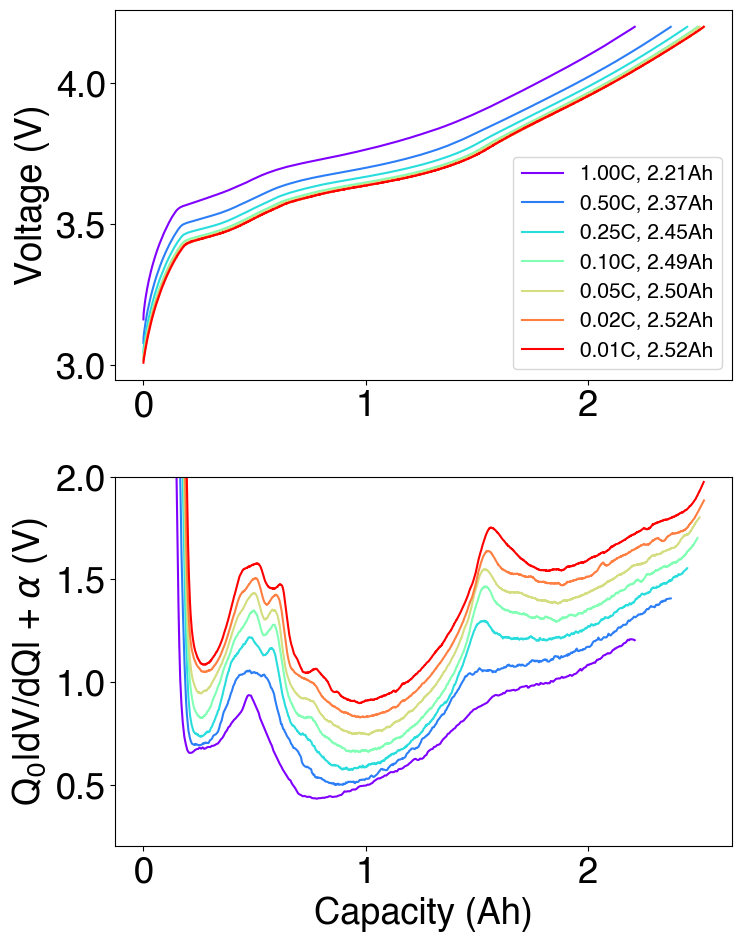

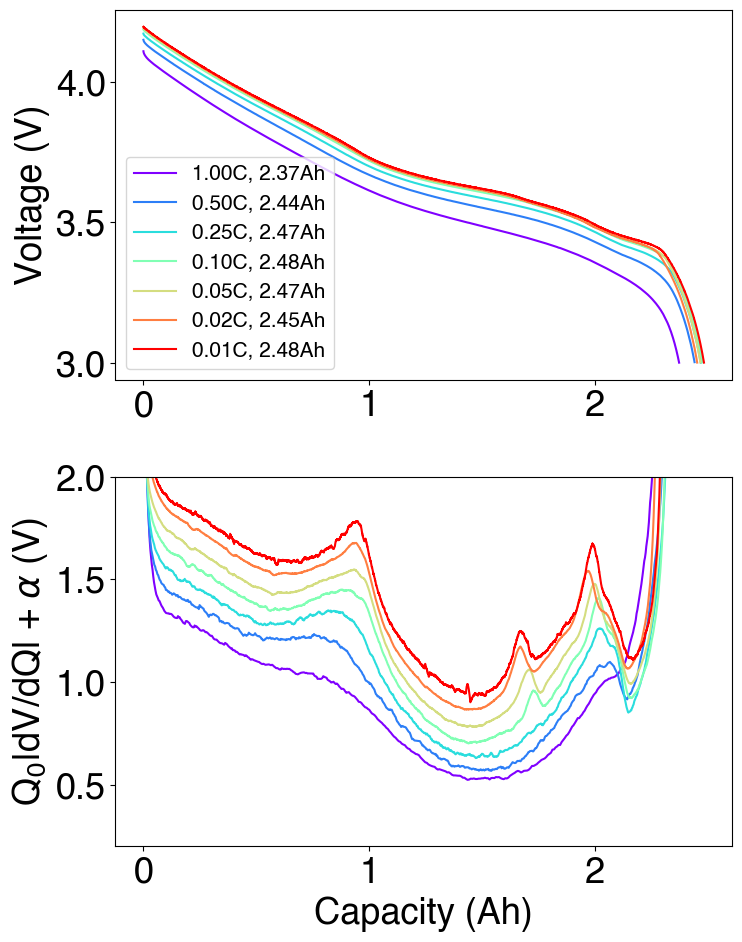

In [28]:
res1 = process_data_set(file_list_1, 'charge')
res1 = process_data_set(file_list_1, 'discharge')

# res2 = process_data_set(file_list_2)

In [29]:
# Add the second set of data 
# Make a plot of capacity sensitivity to C-rate, including CC/CV
def make_crate_plot(res):

    plt.figure(figsize=(7, 7))

    plt.plot(1/res['c_rate_array'], res['chg_cap_array'], marker='o', label='Charge CC', color='r')
    plt.plot(1/res['c_rate_array'], res['dch_cap_array'], marker='^', label='Discharge CC', color='b')
    plt.plot(1/res['c_rate_array'], res['chg_cap_cv_array'], marker='o', label='Charge CC+CV', color='r', linestyle='--')
    plt.plot(1/res['c_rate_array'], res['dch_cap_cv_array'], marker='^', label='Discharge CC+CV', color='b', linestyle='--')

    plt.xlabel('C-Rate')
    ax = plt.gca()
    ax.set_xscale('log')
    plt.ylabel('Capacity (Ah)')
    plt.grid(False)
    plt.legend(fontsize=18);

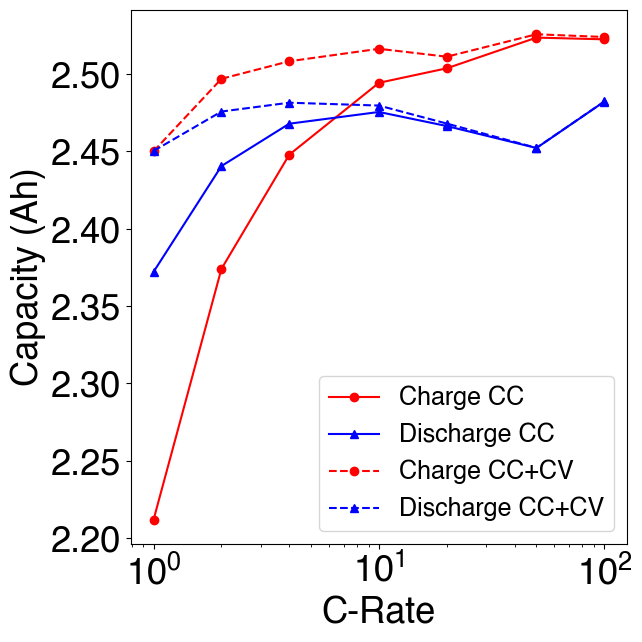

In [30]:
make_crate_plot(res1)
# make_crate_plot(res2)